In [9]:
import chainer
import chainer.functions as F
import chainer.links as L
import numba
from numba import jit
from chainer import training
from chainer.training import extensions
from chainer.datasets import TupleDataset
from chainer.dataset import DatasetMixin
import pandas as pd 
import PIL 
from PIL import Image 
import numpy as np
from chainer.dataset import concat_examples
from chainer.cuda import to_cpu

from chainer import cuda, Chain
from chainer import optimizers
from chainer import serializers
from chainer import links, functions, Variable

from scipy import ndimage, misc
import pickle as pic



In [10]:
def source_image_data(data_file, label_col, image_col, remove_nas): 
    
    if remove_nas:
        data_file = data_file.dropna(subset=[image_col, label_col])  # remove missing data for now 
    
    image_list = data_file[image_col].tolist()
    label_list = data_file.index
    
    return image_list, label_list 


In [11]:
def convert_to_greyscale(fp, new_path, imname):
    """Converts an image to greyscale"""
    img = Image.open(fp).convert('L')
    np = new_path + imname
    img.save(np)
    return np

In [12]:
def resize_iamge(fp):
    
    image = ndimage.imread(fp, mode="L")
    image_resized = misc.imresize(image, (112, 112))
    return image_resized

def get_image(image_path):
    """Get a numpy array of an image so that one can access values[x][y]."""
    image = Image.open(image_path, 'r')
    print(image.size)
    width, height = image.size
    pixel_values = list(image.getdata())
    if image.mode == 'RGB':
        channels = 3
    elif image.mode == 'L':
        channels = 1
    else:
        print("Unknown mode: %s" % image.mode)
        return None
    pixel_values = np.array(pixel_values).reshape(width, height, channels)
    return pixel_values

def load_images(path_name, image_list): 
    
    imlist = []
    for i in image_list:
        #fp = path_name + i
        fp = convert_to_greyscale(path_name + i, "images/", "grey_" + i)
        image = ndimage.imread(fp, mode = "L")
        image_resized = misc.imresize(image, (128, 128, 3))
#         image_resized = np.expand_dims(image_resized, axis=0)
        prep_image = chainer.links.model.vision.vgg.prepare(image_resized)
        imlist.append(prep_image)
        
    return imlist

In [13]:
def format_for_chainer(images, labels): 

    return TupleDataset(images, labels)

In [14]:
def split_data(all_x, all_y, prop=0.8):
    indices = np.random.permutation(len(all_x))
    thresh = int(len(all_x) * prop)
        
    all_y = np.array([-1 if np.isnan(y) else y for y in all_y])
    
    all_x, all_y = all_x[indices], all_y[indices]
    train_x, test_x = all_x[:thresh], all_x[thresh:]
    train_y, test_y = all_y[:thresh], all_y[thresh:]
    train_x, test_x = train_x.astype(np.float32), test_x.astype(np.float32)
    return [train_x, train_y], [test_x, test_y]

In [15]:
df_enc = pd.read_csv("/home/ccaggian/BachelorPredict/encoded.csv")
df_all = pd.read_csv("/home/ccaggian/BachelorPredict/one_hot_encoded.csv")
df_all.index = df_all["Name"]
df_enc.index = df_all["Name"]
df_enc = df_enc.drop(columns = ["Season", "intro_order"])
df_enc.head(5)

,ElimWeek,Employment.full.time,Employment.part.time,Employment.student,Employment.unemployed,Education.Needed.college,Education.Needed.high.school,Education.Needed.post.college,Region.west,Region.midwest,...,hair_wavy.straight.medium,hair_wavy.medium,hair_wavy.curly,hair_wavy.curly.medium,hair_length.chest,hair_length.shoulder,hair_length.stomach,hair_length.neck,hair_length.medium.dark,hair_length.short
Name,,,,,,,,,,,,,,,,,,,,,
Alexa,2.0,1,0,0,0,1,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Amanda Marsh,NaN,0,1,0,0,1,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Amber,1.0,1,0,0,0,1,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Amy,2.0,1,0,0,0,0,1,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Angela,2.0,0,1,0,0,0,1,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
gpu_id = -1

# hardcoded garbage that gets the csv and the appropriate labels/image data 
data_file = pd.read_csv("/home/ccaggian/bachelor_data/bachelor_females_images.csv") 
image_folder_path = "/home/ccaggian/bachelor_data/images/"

label_col = "ElimWeek"  # column with labels (week eliminated)
image_col = "image"  # column with data (jpegs)

images, labels = source_image_data(data_file, label_col, image_col, True)  # get appropriate data in list for chainer, remove nans

images = load_images(image_folder_path, images)  # give appropriate absolute path of image data 

train_data = format_for_chainer(images, labels)
print(max(["ElimWeek"]))
data_file.tail(5)

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


ElimWeek


,Name,Age,Occupation,Hometown,Height,ElimWeek,Season,hair_wavy,hometown_name,height_inches,...,photo_url,hometown_state,ethnicity,goneweek,featured,featured_num,intro_order,hometown_pop_2010,hometown_pop_2013,image
419,Vienna Girardi,23.0,Marketing Representative,"Geneva, Florida",NaN,NaN,14.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Vienna_Bachelor_14.jpg
420,Wendi,26.0,Technology Specialist,"Dallas, Texas",NaN,1.0,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
421,Whitney,25.0,Pilates Instructor,"Chanhassen, MN",68.0,6.0,21.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Whitney_Bachelor_21.jpg
422,Whitney Bischoff,29.0,Fertility Nurse,"Louisville, Kentucky",NaN,NaN,19.0,medium,Chicago,67.0,...,NaN,IL,caucasian,NaN,True,4.0,2.0,2698000.0,2719000.0,NaN
423,Nicole,NaN,NaN,NaN,NaN,NaN,NaN,straight-medium,Scottsdale,68.0,...,http://static.east.abc.go.com/service/image/ra...,AZ,caucasian,1.0,NaN,NaN,23.0,217558.0,226918.0,NaN


In [17]:
class DeepNN(chainer.Chain):

    def __init__(self):
        super(DeepNN, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, 2000)
            self.l2 = L.Linear(None, 1000)
            self.l3 = L.Linear(None, 500)
            self.l4 = L.Linear(None, 100)
            self.l5 = L.Linear(None, 1)
        
        

    def __call__(self, x):
        h1 = F.leaky_relu(self.l1(x))
        h2 = F.leaky_relu(self.l2(h1))
        h3 = F.leaky_relu(self.l3(h2))
        h4 = F.leaky_relu(self.l4(h3))
        h5 = F.relu(self.l5(h4))
        return h5

In [19]:
class VGG(Chain):

    def __init__(self):
        super(VGG, self).__init__()
        with self.init_scope():
            self.base = L.VGG16Layers()  


    def __call__(self, x):
        # refer to https://github.com/chainer/chainer/blob/master/chainer/links/model/vision/vgg.py for 
        # all possilbe layers to extract.
        h = self.base (x, layers = ["fc8"])["fc8"]
        return h

In [20]:
# Section to create a fully connected input layer from images and extra variables

model = VGG()

train_iter = chainer.iterators.SerialIterator(train_data, batch_size=1, shuffle=False)

features = []
targets = []
i = 0
for t in train_data:
    print(str(i) + " of " + str(len(train_data)))
    image_train, target_train = concat_examples([t], -1)
    proc = model(image_train)
    r = df_enc.iloc[target_train[0]]
    
    # Target is week eliminated
    target = r["ElimWeek"]
    
    # if NAN it means we didn't have data - setting to -1 to not cause an error
    r[np.isnan(r)] = -1
    r = np.array(r.astype(np.float32))
    proc = [p.data for p in proc[0]]
    
    # add extra variables to output of image net
    proc = np.append(proc, r[1:])
    
    features.append(proc)
    targets.append(target)
    i += 1


0 of 198


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5984: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


1 of 198
2 of 198
3 of 198
4 of 198
5 of 198
6 of 198
7 of 198
8 of 198
9 of 198
10 of 198
11 of 198
12 of 198
13 of 198
14 of 198
15 of 198
16 of 198
17 of 198
18 of 198
19 of 198
20 of 198
21 of 198
22 of 198
23 of 198
24 of 198
25 of 198
26 of 198
27 of 198
28 of 198
29 of 198
30 of 198
31 of 198
32 of 198
33 of 198
34 of 198
35 of 198
36 of 198
37 of 198
38 of 198
39 of 198
40 of 198
41 of 198
42 of 198
43 of 198
44 of 198
45 of 198
46 of 198
47 of 198
48 of 198
49 of 198
50 of 198
51 of 198
52 of 198
53 of 198
54 of 198
55 of 198
56 of 198
57 of 198
58 of 198
59 of 198
60 of 198
61 of 198
62 of 198
63 of 198
64 of 198
65 of 198
66 of 198
67 of 198
68 of 198
69 of 198
70 of 198
71 of 198
72 of 198
73 of 198
74 of 198
75 of 198
76 of 198
77 of 198
78 of 198
79 of 198
80 of 198
81 of 198
82 of 198
83 of 198
84 of 198
85 of 198
86 of 198
87 of 198
88 of 198
89 of 198
90 of 198
91 of 198
92 of 198
93 of 198
94 of 198
95 of 198
96 of 198
97 of 198
98 of 198
99 of 198
100 of 198
101 of 1

In [180]:
## Save features and targets as a pickle file for future
pic.dump(features, open("bachelor_features.pkl", "wb"))
pic.dump(targets, open("bachelor_targets.pkl", "wb"))


In [21]:

train, test = split_data(np.array(features), np.array(targets))

train[1], test[1] = np.expand_dims(train[1].astype(np.float32), axis=1), np.expand_dims(test[1].astype(np.float32), axis=1)

print(train[0].shape)
train, test = format_for_chainer(train[0], train[1]), format_for_chainer(test[0], test[1])


(158, 1024)


In [26]:


model = L.Classifier(DeepNN(), lossfun=F.mean_squared_error, accfun = F.r2_score)
optimizer = chainer.optimizers.SGD(lr=0.0009)
optimizer.setup(model)

train_iter = chainer.iterators.SerialIterator(train, batch_size=60, repeat=True, shuffle=True)
test_iter = chainer.iterators.SerialIterator(test, batch_size=10, repeat=False, shuffle=False)
    
#Set up a trainer
updater = training.StandardUpdater(train_iter, optimizer, device=-1)
trainer = training.Trainer(updater, (300, 'epoch'), out='result')
    
trainer.extend(extensions.Evaluator(test_iter, model, device=-1))
trainer.extend(extensions.LogReport())
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'main/accuracy', 'validation/main/loss', 'validation/main/accuracy', 'elapsed_time']))
trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'], x_key='epoch', file_name='loss.png'))
trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'], x_key='epoch', file_name='accuracy.png'))
trainer.extend(extensions.ProgressBar())
    
#Run the training
trainer.run()

epoch       main/loss   main/accuracy  validation/main/loss  validation/main/accuracy  elapsed_time
1           18.4178     -1.88065       10.0646               -1.47186                  0.245214      
2           10.879      -0.528309      4.7601                -0.122395                 0.464364      
3           7.66894     -0.109783      5.59453               -0.360808                 0.668818      
4           7.378       -0.0490367     4.71723               -0.106021                 0.905862      
5           6.67578     -0.0604032     4.8816                -0.134818                 1.14212       
6           7.45538     0.0217827      5.20249               -0.249437                 1.36155       
7           6.5562      0.0825782      5.32031               -0.282506                 1.59272       
8           5.82854     0.106619       5.16948               -0.241531                 1.82546       
9           6.82248     0.0269502      5.48743               -0.328659              

     total [############......................................] 25.32%
this epoch [###############################################...] 94.94%
       200 iter, 75 epoch / 300 epochs
    9.6013 iters/sec. Estimated time to finish: 0:01:01.450119.
76          4.95679     0.317723       7.18214               -0.895577                 20.4417       
77          2.47213     0.602246       5.30643               -0.3645                   20.6643       
78          1.39878     0.804595       4.77309               -0.214528                 20.9156       
79          1.07711     0.837963       5.01642               -0.295165                 21.1617       
80          0.980775    0.873043       5.23918               -0.369956                 21.6389       
81          1.90356     0.737254       6.94107               -0.718819                 21.8878       
82          3.15727     0.480556       4.89704               -0.210151                 22.1261       
83          1.32328     0.803875       5.

150         0.500794    0.927721       4.6518                -0.174161                 39.8379       
151         0.553547    0.923497       6.24149               -0.696125                 40.093        
     total [#########################.........................] 50.63%
this epoch [############################################......] 89.87%
       400 iter, 151 epoch / 300 epochs
    9.8932 iters/sec. Estimated time to finish: 0:00:39.420899.
152         1.08839     0.819202       5.51212               -0.367226                 40.3573       
153         1.13183     0.837754       4.67406               -0.187138                 40.6033       
154         0.351217    0.947963       5.06903               -0.347791                 40.8609       
155         0.224159    0.968545       4.6013                -0.188725                 41.1186       
156         0.243673    0.963811       4.60549               -0.18514                  41.3574       
157         0.220463    0.968012       4

224         0.0465769   0.993317       4.68518               -0.246693                 59.2206       
225         0.0385177   0.994382       4.63434               -0.228561                 59.4628       
226         0.048968    0.993278       4.684                 -0.246303                 59.7054       
227         0.0396296   0.994383       4.73123               -0.262846                 59.9283       
     total [#####################################.............] 75.95%
this epoch [##########################################........] 84.81%
       600 iter, 227 epoch / 300 epochs
    9.9706 iters/sec. Estimated time to finish: 0:00:19.056017.
228         0.0576554   0.991563       4.6011                -0.216327                 60.1722       
229         0.034234    0.994994       4.70308               -0.253345                 60.4368       
230         0.0564693   0.990946       4.70494               -0.253907                 60.6713       
231         0.0461691   0.993855       4

298         0.0267803   0.996735       4.69465               -0.249789                 77.538        
299         0.0408072   0.993861       4.62344               -0.224803                 77.7858       
300         0.0445768   0.99321        4.61383               -0.22175                  78.0135       


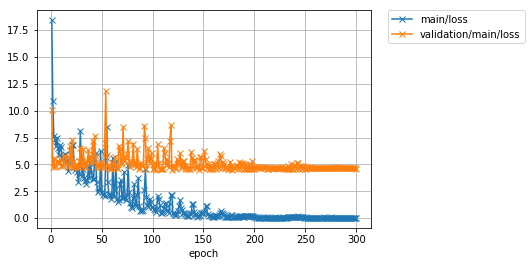

In [27]:
from IPython.display import Image

Image(filename = "result/loss.png")

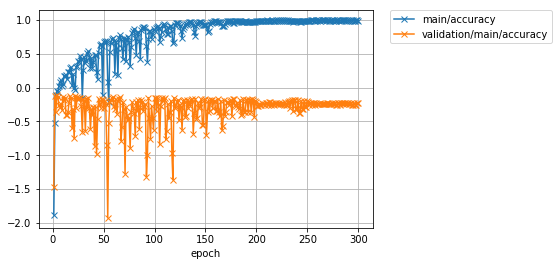

In [28]:
from IPython.display import Image

Image(filename = "result/accuracy.png")